<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучим-эмбеддинги" data-toc-modified-id="Изучим-эмбеддинги-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучим эмбеддинги</a></span><ul class="toc-item"><li><span><a href="#Первичный-анализ" data-toc-modified-id="Первичный-анализ-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Первичный анализ</a></span></li><li><span><a href="#Расмотрим-подробно-признаки" data-toc-modified-id="Расмотрим-подробно-признаки-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Расмотрим подробно признаки</a></span></li></ul></li><li><span><a href="#Baseline" data-toc-modified-id="Baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Baseline</a></span><ul class="toc-item"><li><span><a href="#Подготовим-данные" data-toc-modified-id="Подготовим-данные-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовим данные</a></span></li><li><span><a href="#Faiss" data-toc-modified-id="Faiss-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Faiss</a></span></li></ul></li><li><span><a href="#Fast-AI" data-toc-modified-id="Fast-AI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fast AI</a></span></li></ul></div>

# Определение жанра по изображению обложки музыкального диска

__Цель__

Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки.

__Данные__

Изображения в формате PNG, упакованные в zip-архивы. Имя архива соответствует музыкальному жанру. Каждый zip-архив содержит папку с изображениями музыкальных обложек соответствующего жанра.

Всего в нашем расорядкении 10 папок с разными жанрами:
 - anime
 - black metal
 - classical
 - country
 - disco
 - edm
 - jazz
 - pop
 - rap
 - reggae

__Метрика__

Метрики для классификации: Accuracy, Precision, Recall, F1.

__План работ__

- исследовательский анализ
- провести предобработку данных
- построить baseline модель на основе алгоритма k-means
- обучить и протестировать модель нейронной сети использую библиотеку fastai
- сделать выводы

In [1]:
# проверим какая среда подключина
!nvidia-smi

Mon May 27 11:33:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# установим faiss
! pip install faiss-cpu -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 34.8 MB/s eta 0:00:00


In [3]:
# установим fastai
! pip install fastai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.0 MB/s eta 0:00:00


In [4]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import torch
import faiss
import seaborn as sns

import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
from fastai.vision.all import *


import warnings
warnings.simplefilter('ignore')

In [5]:
# подключим гугул диск
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
# проверяем работу диска
!pwd

/content


In [7]:
# смотрим на путь к файлам
!ls /content/drive/MyDrive/df

 anime	'black metal'   classical   country   disco   edm   jazz   models   pop   rap   reggae


In [8]:
# константы
SEED = 42                                              # случайные числа
BATCH_SIZE = 32                                        # размер батча
K_NEIGHBORS = 1                                        # количество соседей
IMG_SIDE_RESIZE = 224                                  # длина стороны изображения для ресайза
IMG_SIDE_CROP = 224                                    # длина стороны изображения для кропа
NORMALIZE_MEAN = [0.485, 0.456, 0.406]                 # mean values для нормализации изображений
NORMALIZE_STD = [0.229, 0.224, 0.225]                  # std values для нормализации изображений
PATH_IMAGES = '/content/drive/MyDrive/df'              # путь к основной папке с изображениями
image_vector = '/content/drive/MyDrive/emb.npy'        # путь к эмбеддингам

# Первичный анализ данных

In [9]:
def uzip_and_show(zip, ):

    ''' Функция загружающаяя картинки из архива.
        На вход принимает полный путь к архиву в формате ziр
        На выходе даёт название жанраи список из картинок в формате PIL.Image
    '''

    imgzip = zipfile.ZipFile(zip)
    inflist = imgzip.infolist()
    flist=[]
    for f in inflist:
        ifile = imgzip.open(f)
        try:
            img = Image.open(ifile)
            flist.append(img)
        except:
            label=os.path.basename(zip)
    return label[:-4],flist

In [15]:
# жанр anime
anime_labels, anime_df = uzip_and_show('/content/drive/MyDrive/df_zip/anime.zip')

# жанр black_metal
black_metal_labels, black_metal_df = uzip_and_show('/content/drive/MyDrive/df_zip/black metal.zip')

# жанр classical
classical_labels, classical_df = uzip_and_show('/content/drive/MyDrive/df_zip/classical.zip')

# жанр country
country_labels, country_df = uzip_and_show('/content/drive/MyDrive/df_zip/country.zip')

# жанр disco
disco_labels, disco_df = uzip_and_show('/content/drive/MyDrive/df_zip/disco.zip')

# жанр edm
edm_labels, edm_df = uzip_and_show('/content/drive/MyDrive/df_zip/edm.zip')

# жанр jazz
jazz_labels, jazz_df = uzip_and_show('/content/drive/MyDrive/df_zip/jazz.zip')

# жанр pop
pop_labels, pop_df = uzip_and_show('/content/drive/MyDrive/df_zip/pop.zip')

# жанр rap
rap_labels, rap_df = uzip_and_show('/content/drive/MyDrive/df_zip/rap.zip')

# жанр reggae
reggae_labels, reggae_df = uzip_and_show('/content/drive/MyDrive/df_zip/reggae.zip')

In [16]:

def show_img(target, features):

    '''
        Функция для просмотра изображени
        На вход подаются название жанра и папка с изображениями
        На выходе 5 изображений каждого жанра
    '''
    fig = plt.figure(figsize=(10,10))
    for i in range(5):
        fig.add_subplot(3, 5, i+1)
        plt.imshow(features[i])
        plt.title(target)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

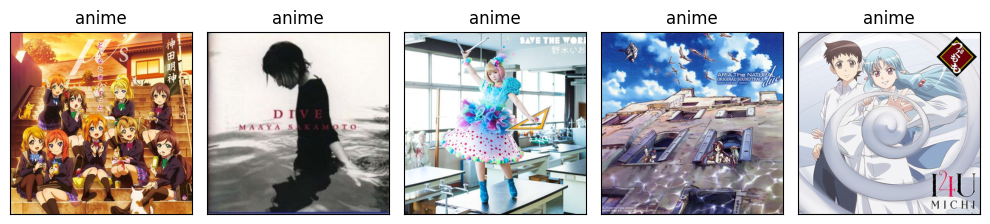

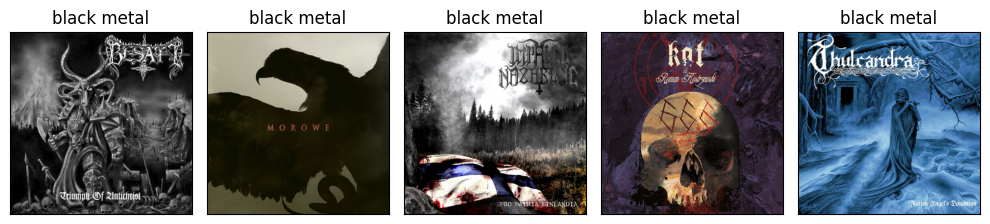

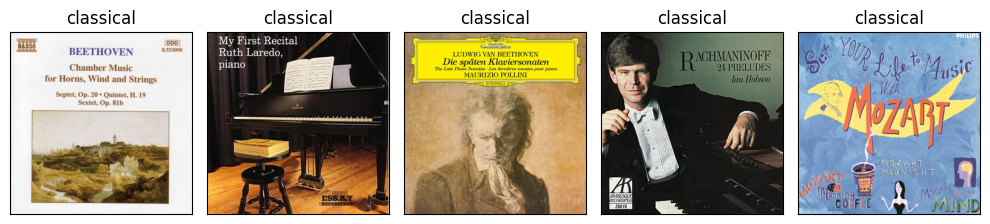

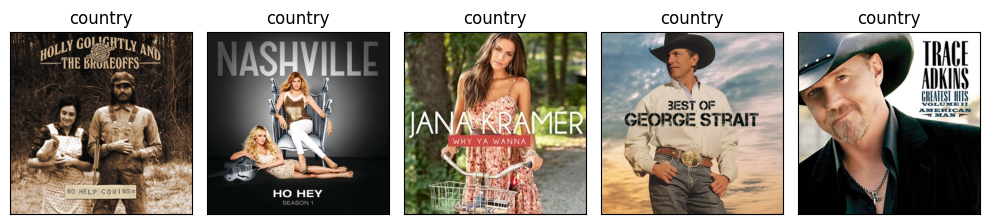

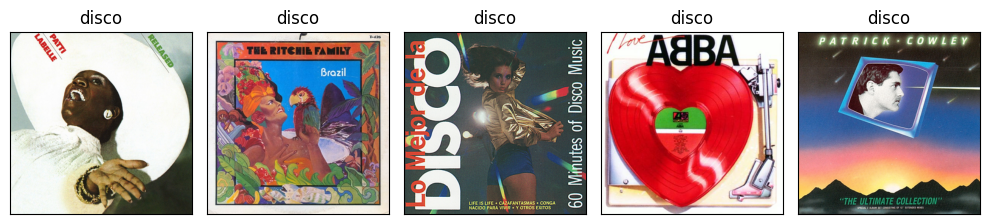

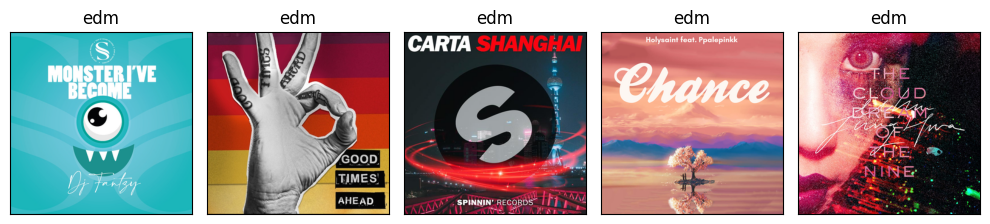

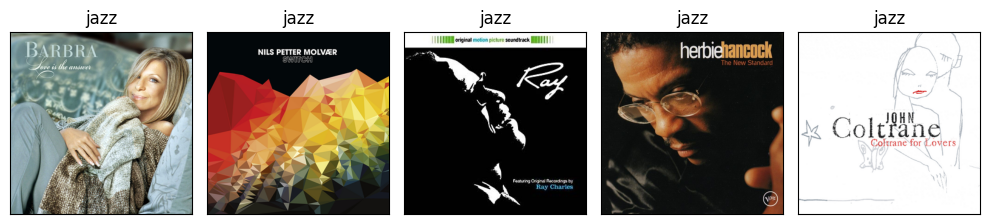

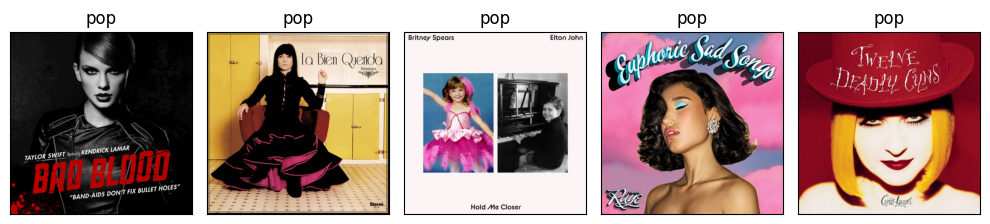

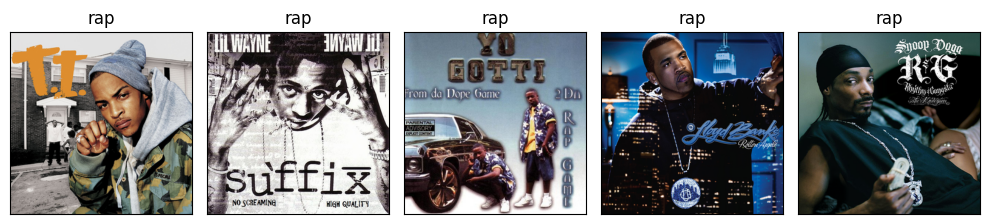

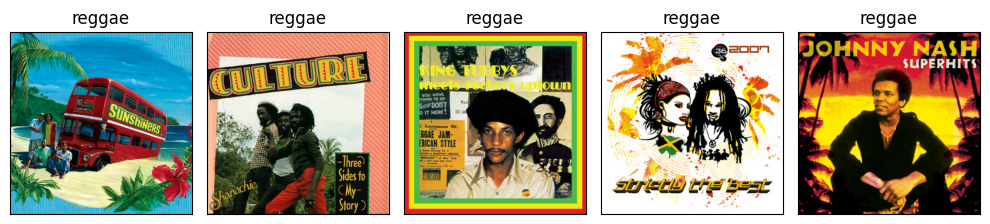

In [17]:
# изображения
show_img(anime_labels, anime_df)
show_img(black_metal_labels, black_metal_df)
show_img(classical_labels, classical_df)
show_img(country_labels, country_df)
show_img(disco_labels, disco_df)
show_img(edm_labels, edm_df)
show_img(jazz_labels, jazz_df)
show_img(pop_labels, pop_df)
show_img(rap_labels, rap_df)
show_img(reggae_labels, reggae_df)

In [18]:
# размер файлов
classical_df[1].size

(300, 300)

__Вывод:__

Визуально есть жанры, обожки которых сложно определить. Размер изображений 300*300. Всего 10 жанров. Стоит проверить альбомы на мультижанровость, возможно один и тот же альбом классифицировался в разные жвнры.

# Получим эмбеддинги

In [19]:
# создадим датафрейм с жанрами и именами изображений
df = pd.DataFrame(columns=['genre', 'image'])

for root, dirs, files in os.walk(PATH_IMAGES):  # возвращает путь к каталогу, список имен подкаталогов и имен файлов
    genre = root.split('/')[-1]
    data = [{'genre': genre, 'image': os.path.join(genre, file)} for file in files]
    df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)

In [20]:
print('Размер датафрейма', df.shape)

Размер датафрейма (7800, 2)


In [21]:
print(df.sample(3)) # проверим как выглядит датафрейм

      genre                                           image
4901  disco  disco/fed9a142-18f8-41c2-8834-25a53fa8b9d2.png
1793   jazz   jazz/4dc46ddd-4e23-4fd2-bb5d-608599e4acae.png
6670    pop    pop/2c00a409-03a8-4702-8c7e-33f85aa1d2df.png


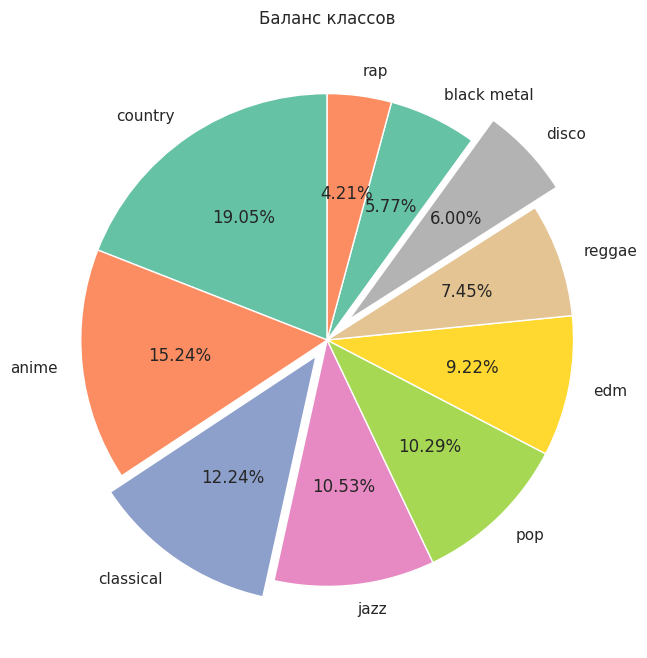

In [22]:
# граффик баланса классов
genre_counts = df['genre'].value_counts()
labels=genre_counts.index
sns.set(font_scale = 1)
plt.figure(figsize=(8,8))

plt.pie(
    x=genre_counts,
    labels=genre_counts.index,
    autopct='%1.2f%%',
    colors=sns.color_palette('Set2'),
    startangle=90,
    explode=[0, 0, 0.08, 0, 0, 0, 0, 0.12, 0, 0]
)
plt.title('Баланс класcов')
plt.show()

__Вывод:__ Наблюдаем дисбаланс класов. К примеру класса Counrty в четыре раза больше, чем Rap.

In [23]:
# Конвейер для препроцессинга изображений
preproc = transforms.Compose([
                              transforms.Resize(IMG_SIDE_RESIZE),
                              transforms.CenterCrop(IMG_SIDE_CROP),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=NORMALIZE_MEAN, std=NORMALIZE_STD),
                             ])

In [24]:
# Модель для векторизации изображений
model_image_vector = resnet50(weights=ResNet50_Weights.DEFAULT)             # предобученная модель resnet50

for param in model_image_vector.parameters():                               # 'заморозка' весов
    param.requires_grad_(False)

layers = list(model_image_vector.children())[:-1]                           # удаление [последнего] слоя для классификации
model_image_vector = nn.Sequential(*layers)                                 # создание модели без слоя для классификации

model_image_vector.eval();

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [25]:
# Функция для векторизации изображений
def get_image_vector(row, path_image):
    img = Image.open(f'{path_image}/{row.image}').convert('RGB')
    image_tensor = preproc(img)
    output_tensor = model_image_vector(image_tensor.unsqueeze(0)).flatten()
    return output_tensor.numpy()

In [ ]:
#tqdm.pandas()
# Создание массива эмбеддингов
#image_vector = df.apply(get_image_vector, path_image=PATH_IMAGES, axis=1)
#image_vector_array = np.vstack(image_vector)

Для удобства сохраним полученные эмбеддинги, что бы не извлекать их каждый раз.

In [26]:
image_vector_array = np.load(image_vector)

In [27]:
print('Размер полученных эмбеддингов', image_vector_array.shape)

Размер полученных эмбеддингов (7800, 2048)


In [28]:
print('посмотрим первые 20 значений', image_vector_array[0][:20])

посмотрим первые 20 значений [8.2330629e-03 8.0212770e-04 1.2369387e-02 0.0000000e+00 2.8674436e-01
 0.0000000e+00 1.0242923e+00 1.1575320e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.6417865e-01 0.0000000e+00 1.4393017e-02 5.2586817e-03
 0.0000000e+00 1.7829038e-01 0.0000000e+00 0.0000000e+00 7.5538498e-03]


In [29]:
# переведем numpy массив полученных эмбеддингов в датафрей
emb_data = pd.DataFrame(data=image_vector_array)

In [30]:
# Посмотрим на веторое представление трех изображений
print(emb_data.sample(3))

          0         1         2         3         4     5     6         7     \
6730  0.000000  0.106294  0.022757  0.070585  0.388668   0.0   0.0  0.299716   
2523  0.055960  0.031433  0.177191  0.000000  0.671351   0.0   0.0  0.040178   
1565  0.042541  0.000000  0.001911  0.000000  1.305411   0.0   0.0  0.000000   

          8     9     ...      2038      2039      2040      2041  2042  \
6730  0.128276   0.0  ...  0.000000  0.018548  0.001918  0.000000   0.0   
2523  0.000000   0.0  ...  0.000000  0.000000  0.015359  0.021995   0.0   
1565  0.000000   0.0  ...  0.208909  0.000000  0.150227  0.001909   0.0   

          2043      2044      2045      2046      2047  
6730  0.042101  0.131678  0.000000  0.000000  0.000000  
2523  0.000000  0.000000  0.012114  0.001282  0.002723  
1565  0.040897  0.000000  0.000000  0.000000  0.051386  

[3 rows x 2048 columns]


## Изучим эмбеддинги

### Первичный анализ

In [31]:
# сделаем копию датасета
temp_emb_data = emb_data.copy()

In [32]:
# функция для первичного анализа
def info(data):
    display(data.info())
    display(data.sample(10))
    display(data.describe().T)
    print(data.isna().sum())
    print('Количество дубликатов: ', data.duplicated().sum())
    print('Количество признаков: ', data.shape[1], 'Количество значений: ', data.shape[0])

In [33]:
info(emb_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 60.9 MB


None

0         1         2         3         4         5         6     \
5950  0.000000  0.000000  0.018941  0.000000  0.051541  0.000000  0.000000   
5397  0.000000  0.000000  0.130458  0.055893  0.360562  0.001157  0.000000   
1780  0.012385  0.005157  0.000000  0.155836  0.430608  0.011883  0.032194   
3921  0.000000  0.037892  0.000000  0.000000  0.000000  0.000000  0.000000   
3356  0.018740  0.000000  0.265565  0.000000  1.008163  0.131859  0.000000   
2075  0.027472  0.009922  0.000000  0.000000  0.448963  0.010722  0.000000   
3608  0.101307  0.018932  0.000000  0.000000  0.006125  0.011196  0.003515   
1546  0.004636  0.000000  0.191219  0.000000  0.266725  0.082639  0.000000   
4358  0.487256  0.012517  0.210045  0.035915  1.806789  0.000000  0.098487   
5576  0.017093  0.020384  0.000000  0.219069  2.300119  0.000000  0.000000   

          7         8         9     ...      2038      2039      2040  \
5950  1.339624  0.087188  0.000000  ...  0.000000  0.038418  0.000000   
5397  2.351720  0.000000  0.000000  ...  0.000000  0.002069  0.167980   
1780  0.158816  0.000000  0.000000  ...  0.001513  0.000000  0.056598   
3921  1.406636  0.000000  0.000000  ...  0.000000  0.057709  0.040154   
3356  0.547590  0.544868  0.000000  ...  0.000000  0.000000  0.000000   
2075  0.864370  0.039372  0.018748  ...  0.120634  0.121729  0.000000   
3608  0.430844  0.000000  0.004979  ...  0.000000  0.000000  0.177191   
1546  1.286378  0.000000  0.208460  ...  0.000000  0.070556  0.000000   
4358  1.035868  0.078090  0.046644  ...  0.109207  0.019288  0.000000   
5576  3.455708  0.023947  0.000000  ...  0.000000  0.058927  0.001941   

          2041      2042      2043      2044      2045      2046      2047  
5950  0.056393  0.000000  0.000000  0.161005  0.000000  0.000000  0.000000  
5397  0.000000  0.000000  0.000000  0.155396  0.077827  0.000000  0.001297  
1780  0.000000  0.012073  0.575662  0.031508  0.000000  0.000000  0.000000  
3921  0.064232  0.015537  0.000000  0.222044  0.000000  0.000000  0.000000  
3356  0.144266  0.000000  0.123801  0.005470  0.000000  0.000000  0.000000  
2075  0.067081  0.000000  0.000000  0.552629  0.107612  0.000000  0.061838  
3608  0.183516  0.000000  0.064718  0.695341  0.234431  0.000000  0.000000  
1546  0.328948  0.000000  0.000000  0.377186  0.006045  0.287283  0.120422  
4358  0.000000  0.000000  0.011940  0.104437  0.090045  0.000000  0.000000  
5576  0.072693  0.004501  0.029587  0.207587  0.000000  0.000000  0.002063  

[10 rows x 2048 columns]

count      mean       std  min       25%       50%       75%       max
0     7800.0  0.066233  0.144571  0.0  0.000000  0.008472  0.070115  2.805491
1     7800.0  0.042414  0.121635  0.0  0.000000  0.000000  0.033768  4.133525
2     7800.0  0.133486  0.243031  0.0  0.000000  0.039586  0.153984  3.387776
3     7800.0  0.063098  0.186768  0.0  0.000000  0.000000  0.030987  3.219333
4     7800.0  1.004602  0.901828  0.0  0.318595  0.769726  1.448047  8.580573
...      ...       ...       ...  ...       ...       ...       ...       ...
2043  7800.0  0.097316  0.197948  0.0  0.000000  0.019703  0.107952  3.021680
2044  7800.0  0.255150  0.457460  0.0  0.000000  0.061565  0.288722  5.516812
2045  7800.0  0.053897  0.138954  0.0  0.000000  0.004418  0.045177  2.507969
2046  7800.0  0.019573  0.087548  0.0  0.000000  0.000000  0.000000  2.428108
2047  7800.0  0.094628  0.197039  0.0  0.000000  0.017819  0.099106  3.611882

[2048 rows x 8 columns]

0       0
1       0
2       0
3       0
4       0
       ..
2043    0
2044    0
2045    0
2046    0
2047    0
Length: 2048, dtype: int64
Количество дубликатов:  52
Количество признаков:  2048 Количество значений:  7800


__Вывод:__

Всего мы имеем 7800 изображений, из них 52 альбома одинаковые. В условиях, когда мы не знаем, какой из дубликатов является прпавильным, лучше удалить все повторяющиеся изображения.

In [34]:
# уберем дубликуты в данных
emb_data.drop_duplicates(keep=False, inplace=True)

In [35]:
# проверим размерность
print('Размер полученного датафрейма', emb_data.shape)

Размер полученного датафрейма (7699, 2048)


In [36]:
# соединим все в один датафрейм
df_join = emb_data.join(df, how='left')

In [37]:
info(df_join)

<class 'pandas.core.frame.DataFrame'>
Index: 7699 entries, 0 to 7799
Columns: 2050 entries, 0 to image
dtypes: float32(2048), object(2)
memory usage: 60.6+ MB


None

0         1         2         3         4         5         6  \
5987  0.000000  0.047969  0.106839  0.064161  0.150484  0.000000  0.000000   
2301  0.040600  0.000000  0.067026  0.000000  0.319025  0.000000  0.001548   
7127  0.000000  0.000000  0.000000  0.000000  0.890756  0.000261  0.000000   
3319  0.000000  0.009445  0.000000  0.000000  0.220037  0.045988  0.399644   
6414  0.000019  0.000000  0.068175  1.210626  1.857470  0.168821  0.083406   
1530  0.029550  0.000000  0.080464  0.039287  0.257592  0.000176  0.010445   
2633  0.602498  0.022857  0.075843  0.000000  0.759858  0.000000  0.422440   
2135  0.205365  0.000000  0.000000  0.000000  0.730183  0.000000  0.000068   
556   0.000000  0.000000  0.000000  0.000000  2.284425  0.001187  0.007878   
3604  0.000000  0.001886  0.116623  0.085621  1.218738  0.000000  0.000000   

             7         8         9  ...      2040      2041      2042  \
5987  0.116227  0.000000  0.000000  ...  0.023783  0.000000  0.000000   
2301  0.772537  0.000000  0.000000  ...  0.071956  0.233725  0.000000   
7127  0.185838  0.020172  0.000000  ...  0.013632  0.000000  0.040562   
3319  0.037349  0.054857  0.346789  ...  0.000000  0.092969  0.091132   
6414  2.344018  0.035683  0.000000  ...  0.000000  0.073623  0.026889   
1530  0.020864  0.519485  0.000000  ...  0.330109  0.000000  0.000000   
2633  0.029860  0.164768  0.000000  ...  0.000000  0.021934  0.001795   
2135  1.666464  0.000000  0.000000  ...  0.032883  0.144452  0.000000   
556   0.159352  0.399027  0.007562  ...  0.414285  0.298276  0.000000   
3604  2.944864  0.000000  0.000000  ...  0.182792  0.160581  0.000000   

          2043      2044      2045      2046      2047      genre  \
5987  0.025294  0.034662  0.000000  0.000000  0.001078      anime   
2301  0.000000  0.016720  0.000000  0.000000  0.000000       jazz   
7127  0.030672  0.015475  0.000000  0.000000  0.000000        pop   
3319  0.000000  0.037840  0.143670  0.000000  0.218123    country   
6414  0.000000  0.149071  0.121102  0.000000  0.353385        rap   
1530  0.000000  0.042775  0.000000  0.000000  0.000000  classical   
2633  0.402167  0.075336  1.077774  0.082575  0.060283        edm   
2135  0.188197  0.542785  0.000000  0.000000  0.000000       jazz   
556   0.000000  0.181597  0.078840  0.000000  0.000000     reggae   
3604  0.000000  0.000000  0.417627  0.000000  0.000000    country   

                                                   image  
5987      anime/dcf6336f-96f9-49d2-a5d3-85bfe4bce8e2.png  
2301       jazz/d03c6f9d-a5f3-43ae-860a-5a92ad2a690e.png  
7127        pop/71a7e44e-aef0-4e91-95b9-4cd3bd8b5a6e.png  
3319    country/16669401-4fc4-3a11-804e-5f2e78130101.png  
6414        rap/71dcb40f-ac9a-41c1-bb85-64b29d41e14c.png  
1530  classical/2cccb6a0-4fe2-4d49-b61f-a7b93b600084.png  
2633        edm/0244d8ef-9540-443d-9557-dc7ba762caa7.png  
2135       jazz/1a2091d2-70eb-4464-8a32-67488a85a312.png  
556      reggae/3d62a148-1288-41b1-afad-5affc65e1175.png  
3604    country/bca28c79-be18-35d7-8c4f-695899f6a838.png  

[10 rows x 2050 columns]

count      mean       std  min       25%       50%       75%       max
0     7699.0  0.066021  0.144685  0.0  0.000000  0.008344  0.069894  2.805491
1     7699.0  0.042362  0.121323  0.0  0.000000  0.000000  0.034086  4.133525
2     7699.0  0.133515  0.243039  0.0  0.000000  0.039465  0.154723  3.387776
3     7699.0  0.063487  0.187713  0.0  0.000000  0.000000  0.031366  3.219333
4     7699.0  1.001529  0.900215  0.0  0.316305  0.767861  1.442510  8.580573
...      ...       ...       ...  ...       ...       ...       ...       ...
2043  7699.0  0.097240  0.197749  0.0  0.000000  0.019654  0.107841  3.021680
2044  7699.0  0.256342  0.458905  0.0  0.000000  0.062087  0.291493  5.516812
2045  7699.0  0.054094  0.139460  0.0  0.000000  0.004427  0.045314  2.507969
2046  7699.0  0.019372  0.086690  0.0  0.000000  0.000000  0.000000  2.428108
2047  7699.0  0.093715  0.193307  0.0  0.000000  0.017603  0.098695  3.611882

[2048 rows x 8 columns]

0        0
1        0
2        0
3        0
4        0
        ..
2045     0
2046     0
2047     0
genre    0
image    0
Length: 2050, dtype: int64
Количество дубликатов:  0
Количество признаков:  2050 Количество значений:  7699


Каждому изображению соответствует свое векторное описание.

### Расмотрим подробно признаки

In [38]:
for col in emb_data.columns:
    print(f'Количество уникальных значений {col}', {emb_data[col].value_counts().count()})

Количество уникальных значений 0 {4557}
Количество уникальных значений 1 {3666}
Количество уникальных значений 2 {5727}
Количество уникальных значений 3 {2864}
Количество уникальных значений 4 {7551}
Количество уникальных значений 5 {3553}
Количество уникальных значений 6 {4845}
Количество уникальных значений 7 {6183}
Количество уникальных значений 8 {4530}
Количество уникальных значений 9 {2501}
Количество уникальных значений 10 {3241}
Количество уникальных значений 11 {3276}
Количество уникальных значений 12 {3263}
Количество уникальных значений 13 {5209}
Количество уникальных значений 14 {4041}
Количество уникальных значений 15 {6879}
Количество уникальных значений 16 {3371}
Количество уникальных значений 17 {2810}
Количество уникальных значений 18 {1320}
Количество уникальных значений 19 {5317}
Количество уникальных значений 20 {2885}
Количество уникальных значений 21 {3943}
Количество уникальных значений 22 {4743}
Количество уникальных значений 23 {3882}
Количество уникальных знач

Признаки имеют как мало уникальных значений, так и много из 7699 возможных.

## Baseline

### Подготовим данные

In [39]:
# разделим выбоку
features = df_join.drop(['genre', 'image'], axis=1)
target = df_join['genre']

In [40]:
# разделим выборку на тренировочную и тестовую
X_train, X_val, y_train, y_val = train_test_split(features,\
                                                    target,
                                                    random_state=SEED,
                                                    stratify=target,
                                                    test_size=0.25)

In [41]:
# сбросим индексы
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)

In [42]:
# сделаем копию датасетов
temp_X_train = X_train.copy()
temp_y_train = y_train.copy()
temp_X_val = X_val.copy()
temp_y_val = y_val.copy()

In [43]:
# посмотрим размер датасетов
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5774, 2048)
(5774,)
(1925, 2048)
(1925,)


### Faiss

In [44]:
def find_neighbor(vec, n):

    '''
       Функция принимает на вход эмбеддинги изображений vec, и число соседий n
       Возвращает жанр наиболее часто встречающийся среди n обложек альбомов наиболее близких к заданному вектору vec
    '''
    dimensions = X_train.shape[1]                       # размер пространиства
    index = faiss.IndexFlatL2(dimensions)               # задает индекс
    index.train(np.ascontiguousarray(X_train))          # обучение индекс на base_trans
    index.add(np.ascontiguousarray(X_train))            # добавим векторы в индекс
    D, I = index.search(np.ascontiguousarray(X_val), n) # записываем расстояние до соседий и индексы
    rez = pd.DataFrame(columns=['genre'])
    for idx in I.flatten():
        rez.loc[len(rez.index)] = [y_train.iloc[int(idx)]]
    return rez

In [45]:
# запишем предсказания
predictions = find_neighbor(X_train, n=K_NEIGHBORS)

In [46]:
print(predictions)

            genre
0       classical
1       classical
2           anime
3       classical
4         country
...           ...
1920          pop
1921      country
1922        anime
1923  black metal
1924        disco

[1925 rows x 1 columns]


In [47]:
print('F_1_weighted с помощью метода ближайших соседий = ', round(f1_score(y_val, predictions, average='weighted'), 2))

F_1_weighted с помощью метода ближайших соседий =  0.47


In [48]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

       anime       0.62      0.65      0.63       295
 black metal       0.77      0.53      0.62       112
   classical       0.53      0.67      0.59       237
     country       0.54      0.55      0.54       370
       disco       0.25      0.21      0.23       116
         edm       0.52      0.39      0.45       170
        jazz       0.36      0.37      0.36       204
         pop       0.35      0.32      0.33       196
         rap       0.39      0.31      0.34        81
      reggae       0.28      0.34      0.31       144

    accuracy                           0.48      1925
   macro avg       0.46      0.43      0.44      1925
weighted avg       0.48      0.48      0.47      1925



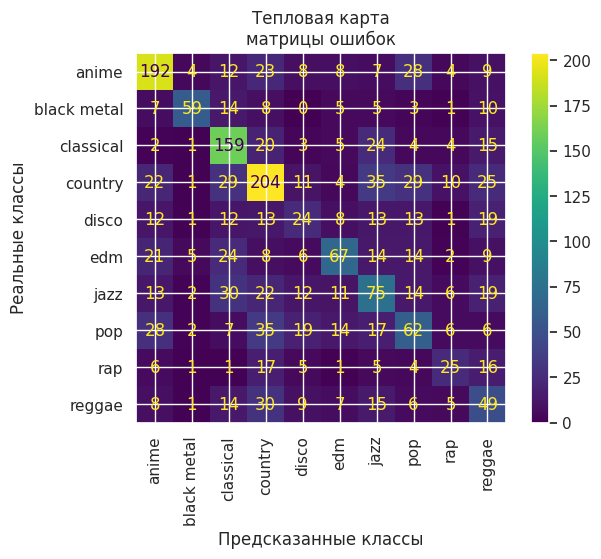

In [64]:
# названия жанров
labels = ['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']

# матрица ошибок


disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions), display_labels=labels)

disp.plot()
plt.title('Тепловая карта\nматрицы ошибок')
plt.xticks(rotation='vertical')
plt.xlabel('Предсказанные классы')
plt.ylabel('Реальные классы')
plt.show()

__Вывод:__

 - С помощью модели knn поиска ближайших соседий по эвклидову расстоянию удалосль добиться метрики F_1_weighted = 0.47

 - Самый спорный жанр для алгоритма — country. Алгоритм часто относит изображения жанра country к других жанрам и, наоборот.

 - Алгоритм распознаёт достаточно хорош изображения жанра anime (192 из 300) и сlassical (159 из 237).

 - Алгоритм практически не распознаёт изображения жанров rap и disco. Вероятно, по причине низкой представленности этих классов в обучающей выборке.

 - accuracy = 0.48. Это значит, что в 48% модель правильно определила жанр альбома.

## Fast AI

In [65]:
# создадим загрузчик данных из папки
dls = ImageDataLoaders.from_folder(path=PATH_IMAGES, valid_pct=0.2, bs=64)
dls.valid_ds.items[:3]

[Path('/content/drive/MyDrive/df/country/3e4a7357-1a69-4a7a-9ed8-ef272101de16.png'),
 Path('/content/drive/MyDrive/df/edm/4149c6f0-c6d2-452b-9af4-57adadb07b63.png'),
 Path('/content/drive/MyDrive/df/anime/fedcecb3-a13c-4110-90e2-0cb990ffd5ce.png')]

In [66]:
# создадим обучкение модели
learn = vision_learner(dls,\
                       models.resnet50,
                       lr=0.001,
                       metrics=[accuracy, Precision(average='weighted'), Recall(average='weighted'), F1Score(average='weighted')],
                       loss_func=CrossEntropyLossFlat())

SuggestedLRs(valley=0.0010000000474974513)

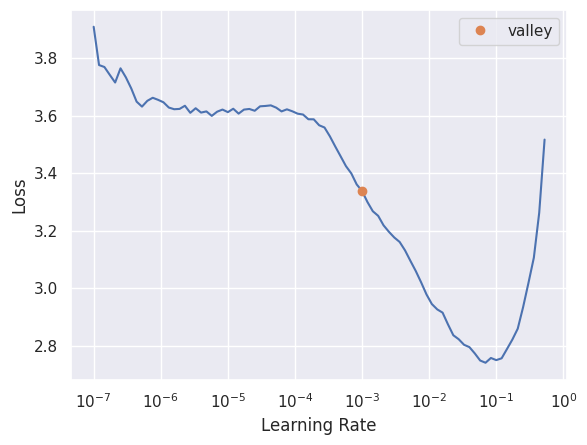

In [67]:
learn.lr_find()

Будем использовать скорость обучения моджели равную 0.001.

In [68]:
# запустим обучение на 10 эпохах
learn.fine_tune(10, 1e-3)

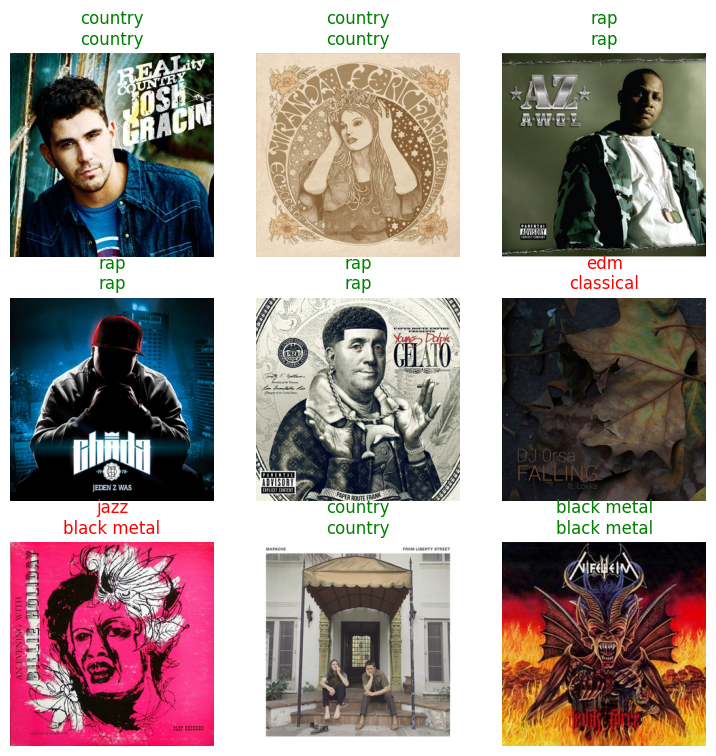

In [69]:
# посмотрим на каких обложках ошибается или нет наша модель
learn.show_results()

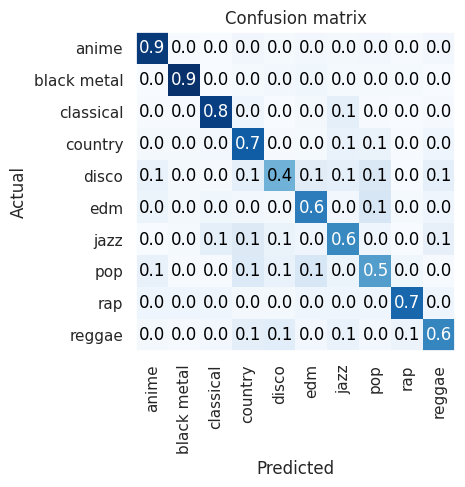

In [70]:
# матрица ошибок по жанрам
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(normalize=True, norm_dec=1)

__Вывод:__

Использую модель ResNet50 на 10 эпохах удалось добиться следующих метрик: accuracy=0.71, precision_score=0.71, recall_score=0.71, f1_score=0.71.

__Общий вывод:__

1) В ходе разработать модель, определит жанр музыкального альбома по изображению его обложки, были изучены обложки 7800 альбомов. Всего предстояла задача разделить имеющиеся изображения альбомов на 10 жанров.

2) Baseline модель была сделана используя метом KNN расчета эвклидово расстояния. Метрика f1_weighted=0.47, при нахожджении одного ближайшего соседа.

3) Использую предобученную модель ResNet50 на 10 эпохах удалось добиться следующих метрик: accuracy=0.71, precision_score=0.71, recall_score=0.71, f1_score=0.71.

4) Анализ модели показа, что имеются облождки, которые очень хорошо отличимы и легко разделяются по жанрам. В частности обложки жанра anime, black metal, classical и country очень хорошо различимы, модель редко ошибается. Такие жанры как pop, disco, edm различимы значительно хуже.

5) Можно порекомендовать для улучшении метрики пересмотреть рассмотрение альбомов по жанрам. К примеру disco и pop можно объединить в один. Так же можно порекомендовать брать так же и обратную сторону для анализа обложки. Выделить текст с обратной стороны и протестировать модель.